In [1]:
import sys
sys.path.append(r'C:\Users\bgiraud\Documents\Thesis Bastien\I - Coding\01 - learning SCOPFs\01 - GLODF')

import cvxpy as cp
import pandas as pd
import numpy as np
import scipy.special as sp
import math
import cvxpy_dcopf as cd
import cvxpy_scopf as cs
#import cvxpy_imb as ci
from cvxpylayers.torch import CvxpyLayer
import torch
import torchvision
import timeit
import precontingency as pc
import torch.nn as nn
import time

from tqdm import tqdm
import itertools
import random

from torch import Tensor
import psutil

import numpy as np
import networkx as nx
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import pickle
import matplotlib.cm as cm
from matplotlib.colors import to_hex


data = pd.read_excel(r'C:\Users\bgiraud\Documents\Thesis Bastien\I - Coding\01 - learning SCOPFs\01 - GLODF\IEEE27.xlsx',sheet_name=None)
Sbase = data['par']['base'][0]
lcontingencies = range(len(data['line']))
Nloads = len(data['load'])
Ngens = len(data['gen'])
Nlines = len(data['line'])
Nbus = len(data['bus'])
l = len(data['line'])
print(data["line"]['max_f'][0]/Sbase)


(CVXPY) Sep 14 12:12:37 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
10.0


In [2]:
from torch.nn.parallel import DataParallel

if torch.cuda.is_available():
    # GPU is available
    device = torch.device('cuda')
    print("GPU is available")
else:
    # GPU is not available
    device = torch.device('cpu')
    print("GPU is not available")


if torch.cuda.device_count() >= 1:
    device_ids = list(range(torch.cuda.device_count()))
else:
    device_ids = None
    
num_workers = torch.cuda.device_count()

GPU is not available


In [3]:
data["bus"].reset_index(drop=True,inplace = True)
ref = data["par"]["refnode"][0]
busmap = dict(zip(data["bus"]["name"],data["bus"].index))
Bmatrix = pc.compB(data,busmap,ref)
print(Bmatrix.shape)


(27, 27)


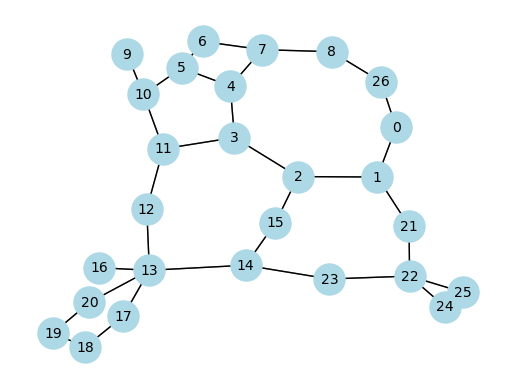

In [4]:
def scale_coordinates(coordinates, xmin, xmax, ymin, ymax):
    min_x = min(coordinates, key=lambda c: c[0])[0]
    max_x = max(coordinates, key=lambda c: c[0])[0]
    min_y = min(coordinates, key=lambda c: c[1])[1]
    max_y = max(coordinates, key=lambda c: c[1])[1]

    scaled_coordinates = []
    for x, y in coordinates:
        scaled_x = ((x - min_x) / (max_x - min_x)) * (xmax - xmin) + xmin
        scaled_y = ((y - min_y) / (max_y - min_y)) * (ymax - ymin) + ymin
        scaled_coordinates.append((scaled_x, scaled_y))

    return scaled_coordinates

# Create a graph from the dataset
G = nx.Graph()
G.add_edges_from(zip(data["line"]["from_bus"], data["line"]["to_bus"]))

# Randomly assign coordinates using the spring layout algorithm
pos = nx.spring_layout(G, seed=56)

# Scale the coordinates to fit within the desired range
scaled_coordinates = scale_coordinates(pos.values(), 0, 200, 0, 200)

# Update the node coordinates in the graph
for node, coordinates in zip(G.nodes(), scaled_coordinates):
    G.nodes[node]["coordinates"] = coordinates

# Compute edge lengths based on the scaled node coordinates
for u, v in G.edges():
    coordinates_u = G.nodes[u]["coordinates"]
    coordinates_v = G.nodes[v]["coordinates"]
    length = math.dist(coordinates_u, coordinates_v)
    G.edges[u, v]["length"] = length

# Print the lengths of each edge
for u, v in G.edges():
    length = G.edges[u, v]["length"]
    #print(f"Edge ({u}, {v}): Length = {length}")

# Draw the graph with node coordinates
fig, ax = plt.subplots()
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, ax=ax)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)

plt.show()

In [5]:
edge_coordinates = np.array(list(itertools.combinations(range(l), 2)))  

def euclidean_distance(G, edge_coordinates, index1, index2):
    u, v = edge_coordinates[index1]
    x, y = edge_coordinates[index2]

    # Get the node indices (u, v) and (x, y) from the graph G
    nodes_uv = list(G.edges())[index1]
    nodes_xy = list(G.edges())[index2]
    u, v = nodes_uv
    x, y = nodes_xy

    distance = math.inf  # Initialize with infinity
    for node_u in [u, v]:
        for node_x in [x, y]:
            coordinates_u = G.nodes[node_u]["coordinates"]
            coordinates_x = G.nodes[node_x]["coordinates"]
            dist = math.dist(coordinates_u, coordinates_x)
            distance = min(distance, dist)

    return distance

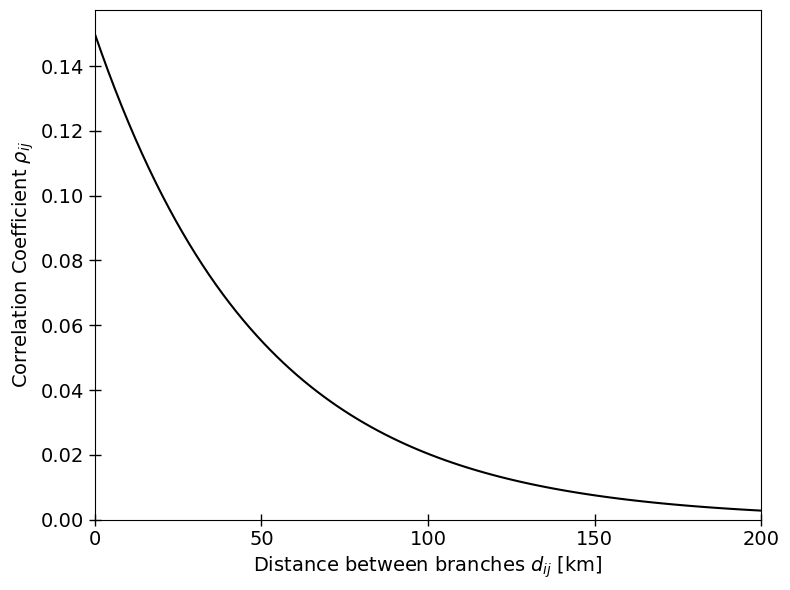

In [42]:
import tikzplotlib

# correlation function
rho_0 = 0.15 # maximal possible correlation
L = 50 # characteristic length


def correlation(distance):
    rho = rho_0*np.exp(-distance/L)
    return rho

# Generate distance values
distances = np.linspace(0, 200, 100)  # Adjust the range and number of points as needed

# Calculate correlation values
correlation_values = correlation(distances)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot the correlation function with markers
plt.plot(distances, correlation_values, color='black', linestyle='-', label = 'Correlation Coefficient $\\rho_{ij}$')

plt.grid(False)

# Set axis labels and title with increased font size
plt.xlabel('Distance between branches $d_{ij}$ [km]', fontsize=14)
plt.ylabel('Correlation Coefficient $\\rho_{ij}$', fontsize=14)

# Set axis limits to start at 0
plt.xlim(0,200)
plt.ylim(0)

# Increase tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Set custom x ticks
custom_xticks = [0, 50, 100, 150, 200]  # Specify your desired x ticks
plt.xticks(custom_xticks)

# Adding a fancy border
ax = plt.gca()
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_color('black')
ax.tick_params(length = 8, which='both', direction='inout', width=1, color='black')
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)

#plt.legend(fontsize=14)

# Fine-tune layout
plt.tight_layout()

#plt.savefig('correlation_plot.png', dpi=300)

tikzplotlib.save('correlation_plot.tex')

# Display the plot
plt.show()

In [43]:
def sigma(individual_probability):
    two_sqrt = np.sqrt(2)
    erf_term = sp.erfinv(2*individual_probability - 1)
    return -1 / (erf_term * two_sqrt)


In [69]:
#=================== Generate, normalize and input line lengths
# Calculate the average length of all edges
total_length = sum(G.edges[u, v]["length"] for u, v in G.edges())
average_length = total_length / len(G.edges())

len_lines_normalized = []
len_lines = []

# Normalize all edge lengths
for u, v in G.edges():
    len_lines.append(G.edges[u, v]["length"])
    len_lines_normalized.append(G.edges[u, v]["length"] / average_length)
    
len_lines_normalized = np.array(len_lines_normalized)
probabilities_values = 0.005*np.ones(l)
individual_probabilities = len_lines_normalized*probabilities_values
no_violation_probability = 1 - np.sum(individual_probabilities)

file_path = 'probabilities/IEEE39/line_lengths.pkl'

# Save the dictionary to the specified file path using pickle
with open(file_path, 'wb') as f:
    pickle.dump(len_lines, f)

In [49]:
def construct_covariance_matrix(individual_probabilities):
    # Create an empty covariance matrix
    covariance_matrix = np.zeros((Nlines, Nlines))
    
    # Populate the covariance matrix using the given formula
    for i in range(Nlines):
        for j in range(Nlines):
            if (i != j):
                covariance_matrix[i, j] = correlation(euclidean_distance(G, edge_coordinates, i, j)) \
                * sigma(individual_probabilities[i]) * sigma(individual_probabilities[j])
            else:
                covariance_matrix[i, j] = sigma(individual_probabilities[i]) * sigma(individual_probabilities[j])
               
    return covariance_matrix

C = construct_covariance_matrix(individual_probabilities) #*0.75

print(C)
print(C.max())

#euclidean_distance(G, edge_coordinates, i, j

[[0.15343235 0.02272709 0.02344533 ... 0.00586212 0.0059083  0.00364326]
 [0.02272709 0.14961949 0.01176259 ... 0.00311818 0.00314274 0.00211258]
 [0.02344533 0.01176259 0.1592257  ... 0.00597177 0.00601881 0.0037114 ]
 ...
 [0.00586212 0.00311818 0.00597177 ... 0.14372835 0.02172908 0.01979575]
 [0.0059083  0.00314274 0.00601881 ... 0.02172908 0.14600166 0.01995169]
 [0.00364326 0.00211258 0.0037114  ... 0.01979575 0.01995169 0.12117671]]
0.1685081273978238


In [50]:
def multivariate_PDF(x, k, C, mu):
    sqrt_term = np.sqrt(((2*math.pi)**k)*np.linalg.det(C))
    exp_term = np.exp(-0.5 * (x - mu).T @ np.linalg.inv(C) @ (x - mu))
    return exp_term/sqrt_term

# x = vector of random variables of length k
# mu = mean of random variables of length k
# C = covariance matrix of size k x k


In [70]:
from scipy.stats import truncnorm
from scipy import integrate

mu = np.ones([Nlines])
case ='N-1'


if case == 'N-1':
    probabilities = individual_probabilities


if case == 'N-2':
    contingency_pairs = np.array(list(itertools.combinations(range(l), 2)))
    probabilities_N2 = []
    k = 2
    
    for i in tqdm(range(len(contingency_pairs))):
        x = contingency_pairs[i]
        mu_pair = mu[x]
        C_pair = np.array([ [C[x[0],x[0]], C[x[0],x[1]]],
                            [C[x[1],x[0]], C[x[1],x[1]]] ])
        
        # Define integration limits for each dimension
        limits = [(-np.inf, 0)] * k

        # Define a wrapper function for multivariate_PDF
        def wrapper(*args):
            return multivariate_PDF(np.array(args), k, C_pair, mu_pair)

        # Perform the integration using scipy.integrate.nquad with the wrapper function
        integral, _ = integrate.nquad(wrapper, limits)

        probabilities_N2.append(integral) 
        
    probabilities = np.array(probabilities_N2)
        
if case == 'N-3':
    contingency_pairs = np.array(list(itertools.combinations(range(l), 3)))
    probabilities_N3 = []
    k = 3
    
    for i in tqdm(range(len(contingency_pairs))):
        x = contingency_pairs[i]
        mu_pair = mu[x]
        C_pair = np.array([ [C[x[0],x[0]], C[x[0],x[1]], C[x[0],x[2]] ],
                            [C[x[1],x[0]], C[x[1],x[1]], C[x[1],x[2]] ],
                            [C[x[2],x[0]], C[x[2],x[1]], C[x[2],x[2]] ] ])
        
        # Define integration limits for each dimension
        limits = [(-np.inf, 0)] * k

        # Define a wrapper function for multivariate_PDF
        def wrapper(*args):
            return multivariate_PDF(np.array(args), k, C_pair, mu_pair)

        # Perform the integration using scipy.integrate.nquad with the wrapper function
        integral, _ = integrate.nquad(wrapper, limits)

        probabilities_N3.append(integral) 
        
    probabilities = np.array(probabilities_N3)



In [60]:
print(probabilities.shape)
print(probabilities.sum())
print(probabilities)

(5456,)
0.002219544983755454
[1.98995220e-06 1.85947593e-06 1.70700129e-06 ... 9.10745437e-08
 9.59748947e-08 9.56411991e-07]


In [71]:
probabilities_final = torch.tensor(probabilities).unsqueeze(1)
probabilities_final_tensor = probabilities_final.repeat_interleave(l, dim=0)
print(probabilities_final_tensor.size(), probabilities_final_tensor.max())

# Specify the file path in Google Drive where the dictionary will be saved
if case == 'N-1':
    file_path = 'probabilities/IEEE39/probabilities_N1.pkl'
if case == 'N-2':
    file_path = 'probabilities/IEEE39/probabilities_N2.pkl'
if case == 'N-3':
    file_path = 'probabilities/IEEE39/probabilities_N3.pkl'

# Save the dictionary to the specified file path using pickle
with open(file_path, 'wb') as f:
    pickle.dump(probabilities_final_tensor, f)

torch.Size([1089, 1]) tensor(0.0074, dtype=torch.float64)


In [62]:
########## compute independent probabilities for comparison

In [63]:
# fill individual probabilities in location
case = 'N-3'

if case == 'N-1': 
    probabilities_index = np.array(list(itertools.combinations(range(l),1)))
elif case == 'N-2':
    probabilities_index = np.array(list(itertools.combinations(range(l),2)))
elif case == 'N-3':
    probabilities_index = np.array(list(itertools.combinations(range(l),3)))
    
probabilities = np.zeros_like(probabilities_index, dtype = float)

# Expected probabi
for i, indices in enumerate(probabilities_index):
    for j, index in enumerate(indices):
        probabilities[i, j] = individual_probabilities[index]
        

In [64]:
# multiply columns
probabilities_final_tensor = torch.tensor(probabilities)
probabilities_final_tensor = probabilities_final_tensor.repeat_interleave(l, dim=0)

if case == 'N-2':
    probabilities_final_tensor = torch.mul(probabilities_final_tensor[:, 0], probabilities_final_tensor[:, 1]).unsqueeze(1)
    
if case == 'N-3':
    probabilities_final_tensor = torch.mul(probabilities_final_tensor[:, 0], torch.mul(probabilities_final_tensor[:, 1], probabilities_final_tensor[:, 2])).unsqueeze(1)


print(probabilities_final_tensor.size(), probabilities_final_tensor.max())

# Specify the file path in Google Drive where the dictionary will be saved
if case == 'N-1':
    file_path = 'probabilities/IEEE39/probabilities_N1_independent.pkl'
if case == 'N-2':
    file_path = 'probabilities/IEEE39/probabilities_N2_independent.pkl'
if case == 'N-3':
    file_path = 'probabilities/IEEE39/probabilities_N3_independent.pkl'

# Save the dictionary to the specified file path using pickle
with open(file_path, 'wb') as f:
    pickle.dump(probabilities_final_tensor, f)

torch.Size([180048, 1]) tensor(3.1092e-07, dtype=torch.float64)


In [65]:
#===================== Base case probabilties
file_path = 'probabilities/IEEE39/probabilities_N1.pkl'
with open(file_path, 'rb') as f:
    probabilities_N1 = pickle.load(f)

file_path = 'probabilities/IEEE39/probabilities_N2.pkl'
with open(file_path, 'rb') as f:
    probabilities_N2 = pickle.load(f)

file_path = 'probabilities/IEEE39/probabilities_N3.pkl'
with open(file_path, 'rb') as f:
    probabilities_N3 = pickle.load(f)
    
#===================== Independent probabilties
file_path = 'probabilities/IEEE39/probabilities_N1_independent.pkl'
with open(file_path, 'rb') as f:
    probabilities_N1_independent = pickle.load(f)

file_path = 'probabilities/IEEE39/probabilities_N2_independent.pkl'
with open(file_path, 'rb') as f:
    probabilities_N2_independent = pickle.load(f)

file_path = 'probabilities/IEEE39/probabilities_N3_independent.pkl'
with open(file_path, 'rb') as f:
    probabilities_N3_independent = pickle.load(f)

In [66]:
case = 'N-3'
if case == 'N-1':
    probability_increase = probabilities_N1.reshape(33,-1)/probabilities_N1_independent.reshape(33,-1)
if case == 'N-2':
    #=========== Make matrix of probabilities N2
    probabilities_N2 = probabilities_N2.reshape(528,-1)
    probabilities_N2_independent = probabilities_N2_independent.reshape(528,-1)
    print(probabilities_N2.size())

    contingency_pairs = np.array(list(itertools.combinations(range(l), 2)))
    upper_prob_matrix_N2 = np.zeros((l, l), dtype=float)
    upper_prob_matrix_N2_ind = np.zeros((l, l), dtype=float)

    for i in tqdm(range(len(contingency_pairs))):
        x = contingency_pairs[i]
        upper_prob_matrix_N2[x[0],x[1]] = (probabilities_N2[i,0])
        upper_prob_matrix_N2_ind[x[0],x[1]] = probabilities_N2_independent[i,0]

    prob_matrix_N2 = upper_prob_matrix_N2 + upper_prob_matrix_N2.T 
    prob_matrix_N2_ind = upper_prob_matrix_N2_ind + upper_prob_matrix_N2_ind.T 

    #=============== Get ratio increase probability
    probability_increase = prob_matrix_N2/prob_matrix_N2_ind
    probability_increase[np.isnan(probability_increase)] = 0
    
if case == 'N-3':
    #=========== Make matrix of probabilities N3
    probabilities_N3 = probabilities_N3.reshape(5456,-1)
    probabilities_N3_independent = probabilities_N3_independent.reshape(5456,-1)
    print(probabilities_N3.size())

    contingency_pairs = np.array(list(itertools.combinations(range(l), 3)))
    upper_prob_matrix_N3 = np.zeros((l, l, l), dtype='float64')
    upper_prob_matrix_N3_ind = np.zeros((l, l, l), dtype='float64')
    prob_matrix_N3 = np.zeros((l, l, l), dtype='float64')
    prob_matrix_N3_ind = np.zeros((l, l, l), dtype='float64')

    for i in tqdm(range(len(contingency_pairs))):
        x = contingency_pairs[i]
        upper_prob_matrix_N3[x[0],x[1],x[2]] = (probabilities_N3[i,0])
        upper_prob_matrix_N3_ind[x[0],x[1],x[2]] = probabilities_N3_independent[i,0]

    for i in range(l):
        prob_matrix_N3[i,:,:] = upper_prob_matrix_N3[i,:,:] + upper_prob_matrix_N3[i,:,:].T
        prob_matrix_N3_ind[i,:,:] = upper_prob_matrix_N3_ind[i,:,:] + upper_prob_matrix_N3_ind[i,:,:].T 

    #=============== Get ratio increase probability
    probability_increase = prob_matrix_N3/prob_matrix_N3_ind
    probability_increase[np.isnan(probability_increase)] = 0


torch.Size([5456, 33])


100%|███████████████████████████████████████████████████████████████████████████| 5456/5456 [00:00<00:00, 65733.66it/s]
C:\Users\bgiraud\AppData\Local\Temp\2\ipykernel_10748\1852529103.py:48: RuntimeWarning: invalid value encountered in divide
  probability_increase = prob_matrix_N3/prob_matrix_N3_ind


13.45849229167935


C:\Users\bgiraud\AppData\Local\Temp\2\ipykernel_10748\3315363837.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Use viridis colormap for clear colors


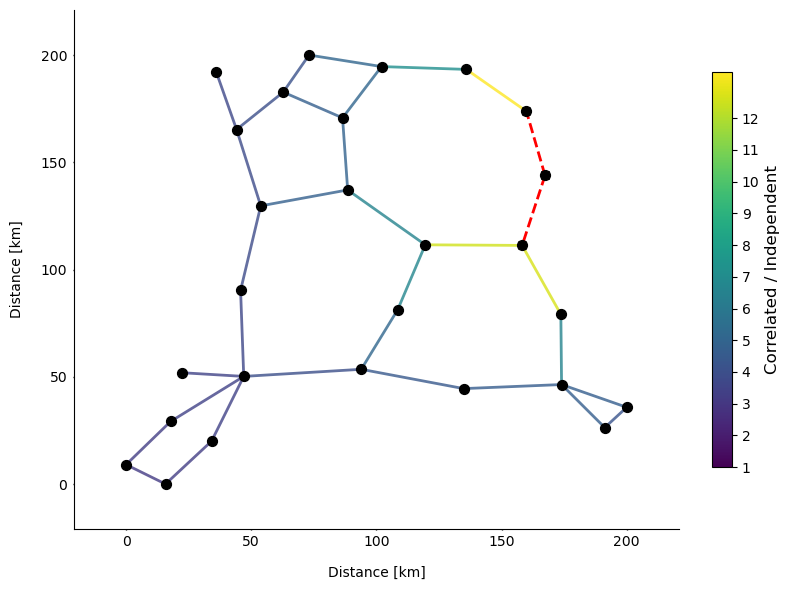

In [67]:
# import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_graph(graph, edge_intensities):
    # Extract node coordinates
    pos = nx.get_node_attributes(graph, 'coordinates')
    
    # Draw the graph
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Define the desired number of colorbar intervals
    num_intervals = 12

    # Create tick values evenly spaced within the normalization range [0, 2]
    tick_values = np.linspace(1, 12, num_intervals)

    # Plot edges with colors based on edge intensities using a colormap
    cmap = cm.get_cmap('viridis')  # Use viridis colormap for clear colors
    #norm = plt.Normalize(vmin=min(edge_intensities), vmax=max(edge_intensities))
    norm = plt.Normalize(vmin=1, vmax=max(edge_intensities)) #max(edge_intensities)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    print(max(edge_intensities))

    # Identify edges with zero intensity
    zero_intensity_edges = [edge for edge, intensity in enumerate(edge_intensities) if intensity == 0]
    non_zero_intensity_edges = [edge for edge in range(len(edge_intensities)) if edge not in zero_intensity_edges]

    # Plot edges with non-zero intensities
    edge_colors = cmap(norm(np.array(edge_intensities)[non_zero_intensity_edges]))
    edges = nx.draw_networkx_edges(graph, pos, edgelist=[list(graph.edges())[edge] for edge in non_zero_intensity_edges],
                                   width=2.0, alpha=0.8, edge_color=edge_colors)  
    
    # Plot edges with zero intensity as red with black crosses
    for edge in zero_intensity_edges:
        u, v = list(graph.edges())[edge]
        ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], linestyle = '--', color='red', linewidth=2) #
        ax.plot(pos[u][0], pos[u][1], marker='x', markersize=6, color='black')
        ax.plot(pos[v][0], pos[v][1], marker='x', markersize=6, color='black')
    
    # Plot nodes as black circles
    nodes = nx.draw_networkx_nodes(graph, pos, node_color='black', node_size=50, alpha=1, edgecolors='k')
    
    # Customize plot appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_tick_params(size=1)
    ax.yaxis.set_tick_params(size=1)
    ax.xaxis.set_tick_params(width=1, color='black')
    ax.yaxis.set_tick_params(width=1, color='black')
    
    plt.xlabel('Distance [km]', color='black', labelpad=12)
    plt.ylabel('Distance [km]', color='black', labelpad=12)
    
    # Add colorbar to show the edge intensity scale
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.05, ticks = tick_values)  # Specify fraction and pad for appropriate positioning
    cbar.set_label('Correlated / Independent', fontsize=12)
    
    plt.tight_layout()
    #plt.savefig('N3_outage_correlation_close.png', dpi=300)
    #tikzplotlib.save('N2_outage_correlation_independent.tex')
    plt.show()

#print(probability_increase[5,6,:])   

plot_graph(G, probability_increase[0,1,:])
#plot_graph(G, probability_increase[5,:])